# The Lineage View

The lineage view allows to explore temporal and spatial single-cell information in interconnected view components. These components include the lineage tree, the microscopy image with the segmentation overlay, single-cell property charts that visualize their temporal development, and a video depicting the trajectory of the single cell in the microscope image. Combined, these components provide an in-depth view on individual cells and their behavior during an experiment.

Have fun 🚀 executing the notebook yourself, experience the freedom of customization in jupyter notebooks, and have a look at the video below 👇


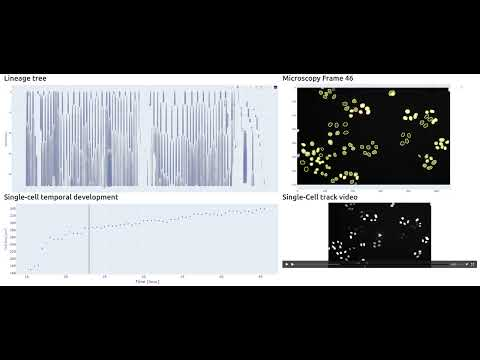

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('8D7AMjg1yLE', width=800, height=300)

## 1. Install dependencies

In [ ]:
!pip install imagecodecs==2023.9.18 igraph==0.11.3 dash[diskcache]==2.14.1 dash-bootstrap-components==1.5.0 multiprocess==0.70.15 "git+https://jugit.fz-juelich.de/publications/acia-pre.git@c989af4c3007882239dd724a2f3a8b13715d0c88#acia" moviepy==1.0.3 ipywidgets==8.1.1

## 2. Download data

In [ ]:
!wget http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DL-HeLa.zip
!unzip -o Fluo-N2DL-HeLa
!mkdir assets

## 3. Load segmentation and tracking information from CTC dataset

In [ ]:
from pathlib import Path
import tifffile

dataset = Path("Fluo-N2DL-HeLa")

pixel_size = 0.645 # micron
frame_step = 1/2 # 30 minutes

mask_path = dataset / "01_ST" / "SEG"
tracking_path = dataset / "01_GT" / "TRA"
image_path = dataset / "01"

In [ ]:
from acia.tracking.output import CTCTrackingHelper

# load data
ov, tracking_graph = CTCTrackingHelper.load_ctc_format(mask_path, tracking_path)

In [ ]:
from tqdm.auto import tqdm
import numpy as np

def norm(im):
    min_quant = np.quantile(im, 0.01)
    max_quant = np.quantile(im, 0.99)
    
    im = (np.clip((im - min_quant) / (max_quant - min_quant), 0, 1) * 255).astype(np.uint8)
    
    if len(im.shape) == 2:
        im = np.stack([im] * 3, axis=-1)
    
    return im

# cache the images for faster computation
images = [norm(tifffile.imread(path)) for path in tqdm(sorted(image_path.glob("t*.tif")), desc="Cache image")]

In [ ]:
# load single-cell information into pandas data frame
import pandas as pd

cell_df = pd.DataFrame([
    {
        "id": cont.id,
        "frame": cont.frame,
        "area": cont.area * (pixel_size **2),
        "contour_coordinates": cont.coordinates,
        "time": cont.frame * frame_step
    } for cont in tqdm(ov)])

cell_df = cell_df.set_index("id")
cell_df

In [ ]:
from acia.tracking.utils import life_cycle_lineage

lc_lineage = life_cycle_lineage(tracking_graph)
lc_lookup = {det_id: cycle_id for cycle_id in lc_lineage.nodes() for det_id in lc_lineage.nodes[cycle_id]["cycle"]}

## 4. Generate lineage layout

In [ ]:
import igraph
from igraph import Graph, EdgeSeq
import networkx as nx
import numpy as np


#id_lookup = {det.id: det for det in ov}

frame = [cell_df.loc[n]["time"] for n in tracking_graph.nodes()]
areas = [cell_df.loc[n]["area"] for n in tracking_graph.nodes()]
max_area = np.max(areas)

max_frame = np.max(frame)

graph = nx.DiGraph()
id_lookup = {id: name for id,name in enumerate(tracking_graph.nodes())}
name_lookup = {name: id for id,name in enumerate(tracking_graph.nodes())}

for id in id_lookup.keys():
    graph.add_node(id)
    
for a,b in tracking_graph.edges():
    graph.add_edge(name_lookup[a], name_lookup[b])

v_label = list(map(str, tracking_graph.nodes))
nr_vertices = graph.number_of_nodes()
print(nr_vertices)
G = Graph(nr_vertices, graph.edges, True) # 2 stands for children number


# perform layoutint
lay = G.layout('rt')
position = {k: lay[k] for k in range(nr_vertices)}
for i,p in enumerate(position):
    lay[i][1] = frame[i]
    

Y = [lay[k][1] for k in range(nr_vertices)]
M = max(Y)

es = EdgeSeq(G) # sequence of edges
E = [e.tuple for e in G.es] # list of edges

L = len(position)
Xn = [position[k][0] for k in range(L)]
Yn = [position[k][1] for k in range(L)] #[2*M-position[k][1] for k in range(L)]
Xe = []
Ye = []
for edge in E:
    Xe+=[position[edge[0]][0],position[edge[1]][0], None]
    Ye+=[position[edge[0]][1],position[edge[1]][1], None]

labels = v_label

## 5. Add utility functions

In [ ]:
def get_frame_overlay(frame: int):
    return cell_df[cell_df["frame"] == frame]

In [ ]:
def get_image_figure(frame:int, selection=None, cell_info=None, draw_track=True):
    image = images[frame][...,0]
    # binary_string for compression
    compression_level=8
    fig = px.imshow(image, binary_string=True, binary_compression_level=compression_level)

    if selection is not None:
        selection = set(selection)
    
    fig.update_layout(autosize=True)

    # obtain the segmentation of the frame
    frame_df = get_frame_overlay(frame)
       
    # loop over all contours in this frame
    for cell_id,contour in frame_df.iterrows():
        
        coordinates = contour["contour_coordinates"]
        x_array = np.array(coordinates[:,0])
        y_array = np.array(coordinates[:,1])

        color = (255,255,0)
        if selection is not None:
            if cell_id in selection:
                color = (255, 0, 0)
        
        text = f'I am cell {cell_id}'
        
        # Adding a trace with a fill, setting opacity to 0
        fig.add_trace(
            go.Scatter(
                x=x_array, 
                y=y_array, 
                fill="toself",
                fillcolor=f'rgba{tuple([*color, 0.0])}',#'rgba(255,255,0,0.5)',
                mode='lines',
                line=dict(
                    color=f"rgb{color}",
                    width=2
                ),
                name=f'Cell id: {cell_id}',
                text=text,
                #opacity=0.2,
            )
        )
        
    fig.update_layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0,
            pad=4
        ),
        height=700
    )

    return fig

In [ ]:
def create_lineage_figure(selection=None):
    
    if selection is None:
        selection = set()
    
    fig = go.Figure()
    
    colors = ['rgb(255, 0, 0)' if cell_id in selection else '#6175c1' for cell_id in tracking_graph]

    fig.add_trace(go.Scatter(x=Xe,
                       y=Ye,
                       mode='lines',
                       line=dict(color='rgb(210,210,210)', width=1),
                       hoverinfo='none'
                       ))
    fig.add_trace(go.Scatter(x=Xn,
                      y=Yn,
                      mode='markers',
                      name='bla',
                      marker=dict(symbol='circle-dot',
                                    size=areas / max_area * 15,
                                    color=colors,#'#6175c1',    #'#DB4551',
                                    line=dict(color='rgb(50,50,50)', width=1)
                                    ),
                      text=labels,
                      hoverinfo='text',
                      opacity=0.8
                      ))



    fig.update_layout(
    #    autosize=False,
    #    width=1700,
        height=700,
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=10,
            pad=4
        ),
    #    paper_bgcolor="LightSteelBlue",
        yaxis_title="Time [hour]",
        showlegend=False,
        xaxis=dict(
            showticklabels=False,
        )
        #title="Lineage Tree"
    )

    # Make the lineage tree show from top to bottom
    fig.update_yaxes(autorange="reversed")
    
    return fig

In [ ]:
from acia.viz import VideoExporter
from tqdm.auto import tqdm
import dash
import uuid

import moviepy.editor as mpy


def render_video(start_frame: int, end_frame: int, selected_cells=None):
    
    if selected_cells is None:
        selected_cells = set()
    
    selected_cells = set(selected_cells)
    
    uid = uuid.uuid4()
    thickness = 2

    video_images = []
    for frame in tqdm(range(start_frame, end_frame + 1)):
        frame_image = np.copy(images[frame])#source.get_frame(frame).raw
        
        #print(frame_image.shape)

        frame_df = get_frame_overlay(frame)
        sel_df = frame_df[frame_df.index.isin(selected_cells)]

        if len(sel_df) > 0:
            cv2.polylines(frame_image, [np.array(contour_coordinates).astype(np.int32) for contour_coordinates in sel_df["contour_coordinates"]], True, (255, 0, 0), thickness)

        video_images.append(frame_image)
        
    clip =  mpy.ImageSequenceClip(video_images, fps=10)
    crf=23
    filename=f"assets/test-{uid}.mp4"
    clip.write_videofile(
            filename, 
            codec='libx264', preset="ultrafast", ffmpeg_params=["-crf", str(crf)],
    )

    return dash.get_asset_url(f'test-{uid}.mp4')


## 6. Create visualization

In [ ]:
from IPython.display import Video, Markdown, display
import dash_bootstrap_components as dbc

import plotly.graph_objects as go
import plotly.express as px

import plotly.io as pio
import cv2
pio.renderers.default = "iframe"

from dash.long_callback import DiskcacheLongCallbackManager

## Diskcache
import diskcache
cache = diskcache.Cache("./cache")
long_callback_manager = DiskcacheLongCallbackManager(cache)

from dash import Dash, dcc, html, Input, Output, callback, no_update, ctx, State
import os
import json

from PIL import Image

L = lambda ch: dcc.Loading(ch, parent_className="loading_wrapper")

app = Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = html.Div([
    dcc.Store(id='memory'),
    dcc.Download(id="download-video"),
    dbc.Row([
        dbc.Col([
            dbc.Row([
                html.H1("Lineage tree"),
                L(dcc.Graph(id="graph", mathjax=True))
                #dcc.Tooltip(id="graph-tooltip"),
            ]),
        ], width=7),
        dbc.Col([
            #dcc.Loading(html.Div(id="single-cell-image"))
            L(dbc.Row([
                html.H1("Microscopy Frame", id="frame-title"),
                html.Div(id="single-cell-image"),
                dcc.Graph(id="image-fig", mathjax=True),
            ])),
            #dbc.Button("Render Video", id="render-video")
        ] , width=5),
    ]),
    dbc.Row([
        dbc.Col([
            html.H1("Single-cell temporal development"),
            L(dcc.Graph(id="single-cell-dev", style={'width': '100%', 'height': '100%'}, mathjax=True)),
        ], width=7),
        dbc.Col([
            html.H1("Single-Cell track video"),
            L(html.Div(id="video")),
        ], width=5)

    ], style={"max-height": "30vh"})

])

@callback(
    Output('selected-data', 'children'),
    Input('graph', 'clickData'))
def display_selected_data(selectedData):
    return json.dumps(selectedData, indent=2)


def b64_image(image_filename):
    with open(image_filename, 'rb') as f:
        image = f.read()
        return 'data:image/png;base64,' + base64.b64encode(image).decode('utf-8')
    
def b64_im(image):
    return 'data:image/png;base64,' + base64.b64encode(image).decode('utf-8')


@app.callback(
    Output("graph", "figure"),
    Output("image-fig", "figure"),
    Output("frame-title", "children"),
    Output("single-cell-dev", "figure"),
    Output("memory", "data"),
    Input("graph", "clickData"),
    Input("image-fig", "clickData"),
    Input("single-cell-dev", "clickData"),
    State("memory", "data")
)
def display_hover(hoverData, image_fig_data, single_cell_dev_data, state):
    # get the trigger id
    trigger_id = ctx.triggered_id
    
    if state is None:
        state = {}
    
    print(trigger_id)

    
    #######################
    # Handle user actions #
    #######################
    
    if trigger_id == "graph":
        # Callback was initiated by click on tracking graph
        pt = hoverData["points"][0]
        bbox = pt["bbox"]
        num = pt["pointNumber"]

        index = pt["pointIndex"]

        # set the current cell_id, detection information and frame
        cell_id = id_lookup[index]
        det = cell_df.loc[cell_id]
        frame = det["frame"]
        
    elif trigger_id == "single-cell-dev":
        # Callback was triggered by a click on the single-cell property graph
        pt = single_cell_dev_data["points"][0]
        index = pt["pointIndex"]
        
        # looking for selected track id at $index
        cell_id = state["selected_cell_id"]
        track_id = lc_lookup[cell_id]
        
        # set the current cell_id, detection information and frame
        cell_id = lc_lineage.nodes[track_id]["cycle"][index]
        det = cell_df.loc[cell_id]
        frame = det["frame"]
    
    elif trigger_id == "image-fig":
        # Callback was triggered by a click on the microscopy image
        
        pt = image_fig_data["points"][0]
        print(pt)
        index = pt["curveNumber"] - 1
        
        # looking for selected track id at $index
        cell_id = state["selected_cell_id"]
        
        frame_df = get_frame_overlay(cell_df.loc[cell_id]["frame"])
        
        # set the current cell_id, detection information and frame
        cell_id = frame_df.index[index]
        det = cell_df.loc[cell_id]
        frame = det["frame"]
        
    else:
        cell_id = cell_df.index[0]
        det = cell_df.loc[cell_id]
        frame = det["frame"]
        
    ################
    # Update views #
    ################
        
    # create the microscopy image figure and visualize the currently selected cell
    image_fig = get_image_figure(frame, selection = [cell_id])
    
    image_fig.update_layout(
        height=600,
        width=1000,
        showlegend=False,
        uirevision='no reset of zoom',
    )

    # add additional information
    children = f"Microscopy Frame {frame}"
        
    # create visualization for single-cell property over time
    life_cycle_id = lc_lookup[cell_id]
    
    cycle = lc_lineage.nodes[life_cycle_id]["cycle"]
    
    area_dev = []
    time = []
    for det_id in cycle:
        area_dev.append(cell_df.loc[det_id]["area"])
        time.append(cell_df.loc[det_id]["time"])
        
    dev_fig = go.Figure()
    dev_fig.add_trace(go.Scatter(x=time, y=area_dev, name="area", mode="markers")) #  marker=dict(symbol='circle-dot',size=50)
    
    dev_fig.add_vline(x=det["time"])
    
    dev_fig.update_layout(
        xaxis_title="Time [hour]",
        yaxis_title=r"$\text{Cell Area [}\mu m^2 \text{]}$",
        font=dict(
            size=18,
            color="RebeccaPurple"
        ),
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=10,
            pad=4
        ),
    )
    
    # update selection state
    state["selected_cell_id"] = cell_id
    
    # create lineage tracking figure with selected cell
    tracking_fig = create_lineage_figure(selection=set([cell_id]))
    
    tracking_fig.update_layout(
        height=600
    )

    return tracking_fig, image_fig, children, dev_fig, state

@app.callback(
    #Output("download-video", "data"),
    Output("video", "children"),
    #Input("render-video", "n_clicks"),
    Input("memory", "data"),
    prevent_initial_call=True,
    manager=long_callback_manager,
)
def renderVideo(state):
    print("Render video...")
    selected_cell = state["selected_cell_id"]
    track_id = lc_lookup[selected_cell]
    
    start_frame = lc_lineage.nodes[track_id]["start_frame"]
    end_frame = lc_lineage.nodes[track_id]["end_frame"]
    
    selected_cells = lc_lineage.nodes[track_id]["cycle"]
    
    print(start_frame, end_frame)
    
    file = render_video(start_frame, end_frame, selected_cells)
    
    # return file upload
    #return dcc.send_file(
    #    file
    #)"""
    print(file)
    return html.Video(src=file, controls = True, style={"width": "100%", "height": "30vh"})


#display(Markdown("# Interactive rendering of the lineage tree"))
app.run_server(port=8050, jupyter_mode="inline", jupyter_height=1200)